# 🏁 Pole to Podium: How F1 Champions Are Made

**QTM 151: Introduction to Statistical Computing II — Final Project**

In [69]:
# Print Names
team_members = [
    "Amanda Middelthon",
    "Anika Chandra",
    "Cassiel Chen",
    "Tianyi Zhang"
]


decorative_line = "~" * 60
print(decorative_line)
print("🌊 TEAM MEMBERS 🌊".center(60))
print(decorative_line)
for member in team_members:
    print(f"~ {member.center(56)} ~")
print(decorative_line)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                      🌊 TEAM MEMBERS 🌊                      
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~                    Amanda Middelthon                     ~
~                      Anika Chandra                       ~
~                       Cassiel Chen                       ~
~                       Tianyi Zhang                       ~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## Section 1: Introduction

Formula 1 (F1) is the world’s premier open‑wheel racing series, where cutting‑edge engineering, peak athlete performance, and split‑second strategy collide.  Since its inaugural season in 1950, F1 has grown into a truly global spectacle—spanning five continents and challenging drivers on a dizzying array of circuits, from high‑altitude mountain tracks to tight street courses.  Fans and analysts alike follow every qualifying session, pit stop and photo finish on [Formula1.com](https://www.formula1.com/) and in encyclopedic resources such as [Wikipedia’s Formula One page](https://en.wikipedia.org/wiki/Formula_One).

![Modern F1 Race Car](https://cdn.ferrari.com/cms/network/media/img/resize/5e5789ba4125497a8dd90672-ferrari-scuderia-f1-2020-galleries-hero-desk?width=1080)  
*Figure 1: A modern Ferrari F1 car in action*

In this notebook, we use five tables—**Drivers**, **Results**, **Circuits**, **Races**, and **Status**—to answer three focused questions. For each question we pull only the necessary tables and, where relevant, use the **Status** table to filter down to classified finishers (“Finished” or “+n Laps”).

1. **Podium by Nationality**  
   - **Tables:** `Drivers`, `Results`  
   - **Notes:** We’ll join `drivers.driverId → results.driverId` and compute a `podium` flag (`positionOrder ≤ 3`).  No additional status filtering is needed since `positionOrder` only applies to classified results.

2. **Circuit Speed**  
   - **Tables:** `Results`, `Circuits`, `Status`  
   - **Notes:** We join `results.circuitId → circuits.circuitId` and `results.statusId → status.statusId`, then filter to `status == "Finished"` or matches `"+n Laps"`.  We’ll convert `milliseconds` and `fastestLapTime` into seconds and compute per-circuit averages.

3. **Nationality Trends Over Time**  
   - **Tables:** `Drivers`, `Results`, `Races`  
   - **Notes:** After joining `results.raceId → races.raceId` (for the `year`) and `results.driverId → drivers.driverId`, we derive each driver’s debut decade and compute `podium` rates by decade for the top nationalities.


We will first load and merge these tables (Section 2), then compute our key metrics and create summary tables and plots for each question (Section 3), and conclude with a brief discussion of our findings (Section 4).  


## Section 2: Data Description

For our analysis, we are focusing on a curated subset of the comprehensive Formula 1 dataset, which comprises 14 tables. We have selected five tables—**Drivers**, **Races**, **Results**, **Circuits**, and **Status**—because they offer a multi-dimensional view of the sport and allow us to filter for classified finishers where needed.

- **Drivers**: Each row represents a unique Formula 1 driver and includes essential details such as the driver's name, nationality, and date of birth. This table provides the backbone for understanding personal attributes and backgrounds.

- **Races**: Captures the details of every race event—race date, round, season, and circuit linkage—spanning the sport’s evolution. We use it to derive decade-of-debut and to join race-level metadata.

- **Results**: Records each driver’s performance in a given race: starting grid, finishing position (`positionOrder`), points, lap counts, total race time (`milliseconds`), fastest lap details, and a `statusId`. This is the core table for our performance, podium, and speed analyses.

- **Circuits**: Describes each race venue—its name, location, country, and altitude—enabling us to examine how track characteristics affect average race and lap times.

- **Status**: Maps `statusId` to finishing status strings (e.g., “Finished”, “Accident”, “+1 Lap”). We join this to **Results** to distinguish true finishers from DNFs or technical retirements, ensuring our circuit-speed calculations and podium denominators are based only on classified outcomes.


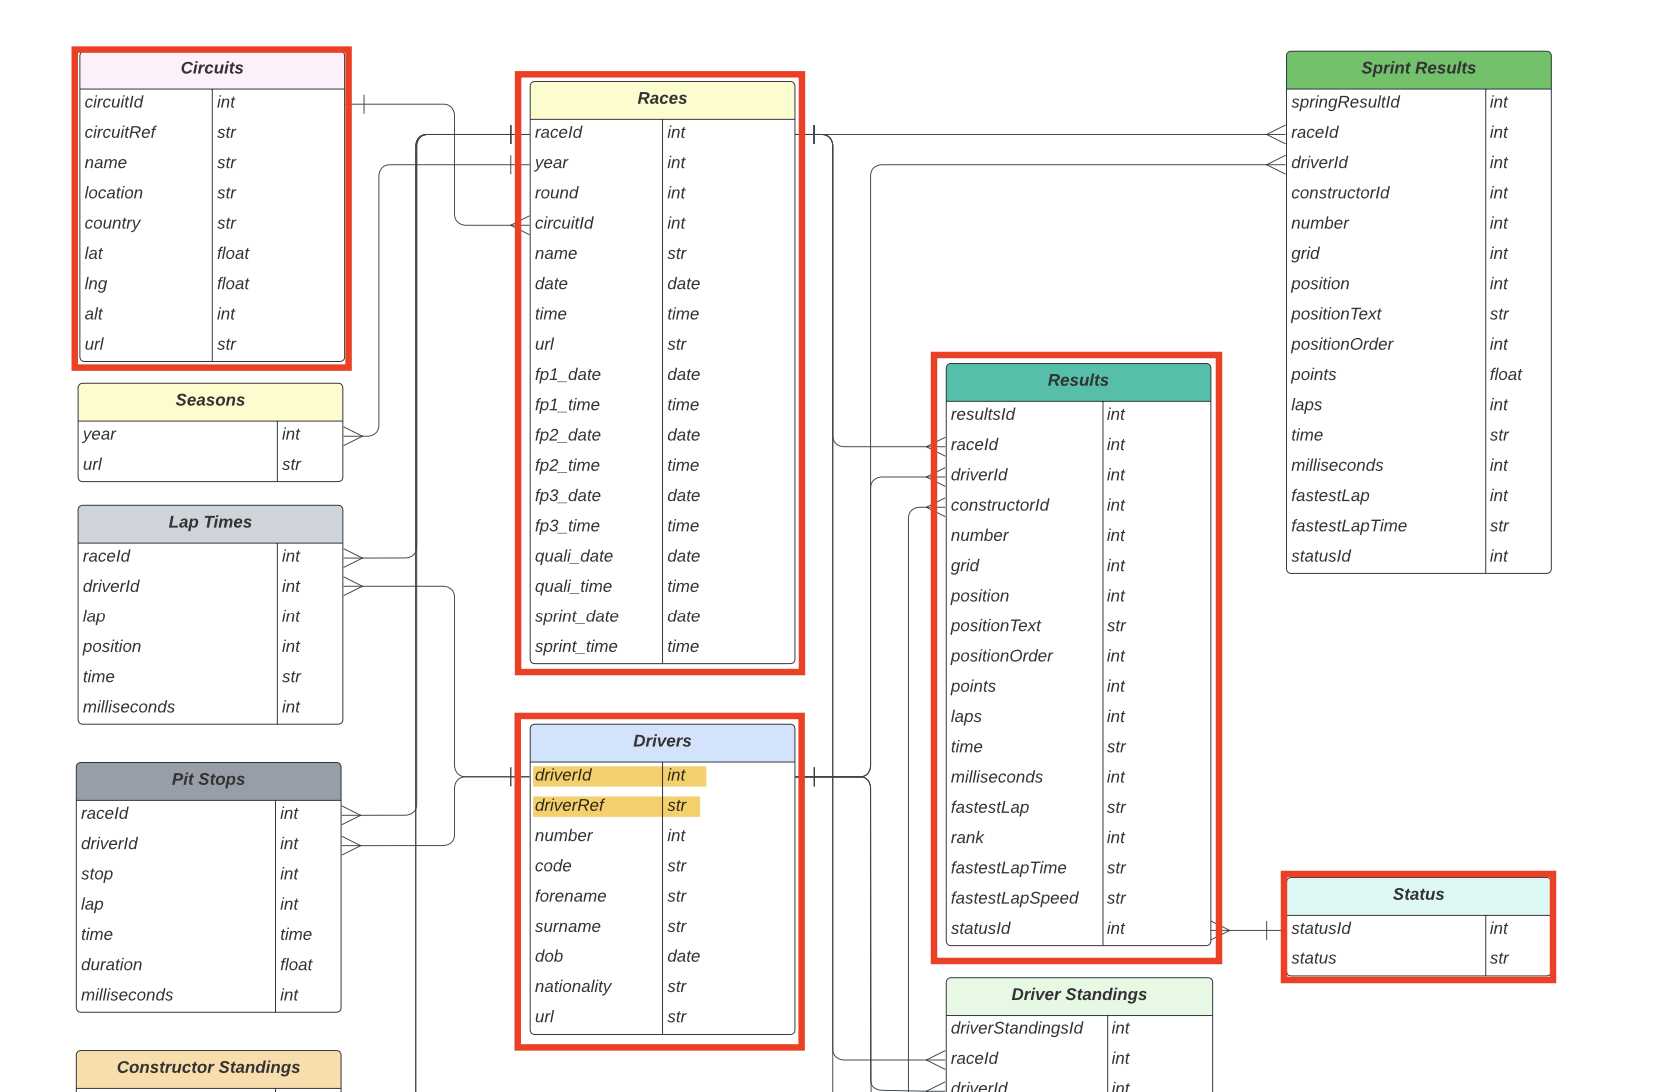


### 2.1 Library Imports and Directory Setup

Before beginning our analysis, we need to import several Python libraries that will help us manipulate data, perform numerical computations, and create visualizations. We also set up our environment by determining the current working directory and specifying the subfolder (`data_raw`) where our raw data is stored. 

- **Pandas** enables efficient data manipulation with its DataFrame objects.
- **NumPy** is used for handling numerical operations and computations.
- **Matplotlib** and **Seaborn** assist in creating both simple and complex visualizations.
- **OS** helps us interact with the operating system to manage file paths.

Below is the code snippet that imports these libraries, configures our plotting settings, and sets the directory for our raw data.


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'data_raw')

# print("Current working directory:", current_dir)
# print("Data directory:", data_dir)

### 2.2 Loading Datasets and Counting Observations

In this section, we load the selected Formula 1 datasets from our specified `data_raw` directory. We work with four key tables:

- **Drivers**: Contains information about each driver, such as name, nationality, and date of birth.
- **Races**: Records details of every race event, including the race date, round, and season.
- **Results**: Provides performance metrics for drivers in each race, such as finishing positions and points scored.
- **Circuits**: Holds details about the race circuits, including circuit name, location, and geographic coordinates.

The following code snippet reads each dataset from its corresponding CSV file and prints out the number of rows to ensure that the data has loaded correctly.


In [71]:
# Load the datasets and count the number of observations in each


drivers = pd.read_csv(os.path.join(data_dir, 'drivers.csv'))
races = pd.read_csv(os.path.join(data_dir, 'races.csv'))
results = pd.read_csv(os.path.join(data_dir, 'results.csv'))
circuits = pd.read_csv(os.path.join(data_dir, 'circuits.csv'))
status = pd.read_csv(os.path.join(data_dir, 'status.csv'))


for df, name in [(drivers, "Drivers"), (races, "Races"),
                 (results, "Results"), (circuits, "Circuits"),
                 (status, "Status")]:
    print(f"{name}: {df.shape[0]} rows × {df.shape[1]} cols")
    display(df.head(2))


Drivers: 857 rows × 9 cols


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld


Races: 1102 rows × 18 cols


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


Results: 25840 rows × 18 cols


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1


Circuits: 77 rows × 9 cols


,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.738,18,http://en.wikipedia.org/wiki/Sepang_Internatio...


Status: 139 rows × 2 cols


,statusId,status
0,1,Finished
1,2,Disqualified


### 2.3 'Drivers' Dataset Exploration

Table Schema

| Field         | Type           | Null | Key | Default | Description                           |
|--------------:|:---------------|:-----|:----|:--------|:--------------------------------------|
| `driverId`    | `int(11)`      | NO   | PRI | —       | Primary key (auto-increment)          |
| `driverRef`   | `varchar(255)` | NO   |     | —       | Unique driver identifier              |
| `number`      | `int(11)`      | YES  |     | —       | Permanent driver number               |
| `code`        | `varchar(3)`   | YES  |     | —       | Driver code (e.g. “ALO”)              |
| `forename`    | `varchar(255)` | NO   |     | —       | Driver forename                       |
| `surname`     | `varchar(255)` | NO   |     | —       | Driver surname                        |
| `dob`         | `date`         | YES  |     | —       | Driver date of birth                  |
| `nationality` | `varchar(255)` | YES  |     | —       | Driver nationality                    |
| `url`         | `varchar(255)` | NO   | UNI | —       | Wikipedia page (unique)               |

The **Drivers** table contains one row per F1 competitor (857 entries). The `driverId` field serves as the internal primary key, while `driverRef` uniquely identifies each driver externally. Permanent race numbers (`number`) and three-letter codes (`code`) are provided when available. Both `forename` and `surname` are required, ensuring clear naming, whereas `dob` and `nationality` may be null if unknown. Finally, the `url` column links to each driver’s Wikipedia page, offering a reliable reference for further biographical details. This schema gives us all the demographic and identity information needed for our nationality-based analyses.  

#### Data Exploration

The **Drivers** dataset contains information for each unique Formula 1 driver, such as their name, nationality, and date of birth. In the code below, we display the first five rows, the detailed dataset information (data types and non-null counts), and summary statistics to understand the structure and composition of the data.


In [72]:
# Preview the first 5 rows of the Drivers dataset
print("Drivers dataset loaded with", drivers.shape[0], "rows.")
print("First 5 Rows of the Drivers Dataset:")
print(drivers.head())

Drivers dataset loaded with 857 rows.
First 5 Rows of the Drivers Dataset:
   driverId   driverRef number code  forename     surname         dob  \
0         1    hamilton     44  HAM     Lewis    Hamilton  1985-01-07   
1         2    heidfeld     \N  HEI      Nick    Heidfeld  1977-05-10   
2         3     rosberg      6  ROS      Nico     Rosberg  1985-06-27   
3         4      alonso     14  ALO  Fernando      Alonso  1981-07-29   
4         5  kovalainen     \N  KOV    Heikki  Kovalainen  1981-10-19   

  nationality                                             url  
0     British     http://en.wikipedia.org/wiki/Lewis_Hamilton  
1      German      http://en.wikipedia.org/wiki/Nick_Heidfeld  
2      German       http://en.wikipedia.org/wiki/Nico_Rosberg  
3     Spanish    http://en.wikipedia.org/wiki/Fernando_Alonso  
4     Finnish  http://en.wikipedia.org/wiki/Heikki_Kovalainen  


Above is a snapshot of the first five rows from the Drivers dataset, which comprises 857 records in total. Each row represents a unique Formula 1 driver and includes key information such as the internal driver ID, an external reference, the driver's racing number (which may be absent in some cases), a short driver code, first name, last name, date of birth, nationality, and a URL linking to their Wikipedia page. For instance, the first entry in this dataset corresponds to Lewis Hamilton, one of the sport’s most celebrated figures. To honor his legacy, we also include an image of him below.

![Lewis Hamilton](https://media.formula1.com/image/upload/f_auto,c_limit,q_auto,w_1320/content/dam/fom-website/drivers/2025Drivers/hamilton)
*Figure 3: Picture of Lewis Hamilton - F1 Driver for Ferrari*

In [73]:
# Display dataset information
print("Dataset Information:")
drivers.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   driverId     857 non-null    int64 
 1   driverRef    857 non-null    object
 2   number       857 non-null    object
 3   code         857 non-null    object
 4   forename     857 non-null    object
 5   surname      857 non-null    object
 6   dob          857 non-null    object
 7   nationality  857 non-null    object
 8   url          857 non-null    object
dtypes: int64(1), object(8)
memory usage: 60.4+ KB


Every column in the **Drivers** table is fully populated, with no missing rows. The only integer field, `driverId`, serves as our primary key for all merges. The other eight columns are stored as strings (or dates once converted), covering identifiers (`driverRef`), personal details (`forename`, `surname`, `dob`, `nationality`), race metadata (`number`, `code`), and reference links (`url`). Several of these—particularly `number`, `code`, `dob`, and `nationality`—use the placeholder `"\N"` for missing entries. In the next step we’ll replace `"\N"` with `NaN` and cast each column to its proper type so that null values are handled correctly in our analyses.  


> **Note on Summary Statistics:** Running a summary statistics table on the **Drivers** table would yield little insight because most fields are unique IDs or high‐cardinality strings. Instead, we’ll generate two focused summaries that directly inform our analysis: a nationality frequency table to show which countries are most represented on the grid and a count of how many drivers have a permanent `number` versus missing entries, revealing how many carry a fixed race number.  


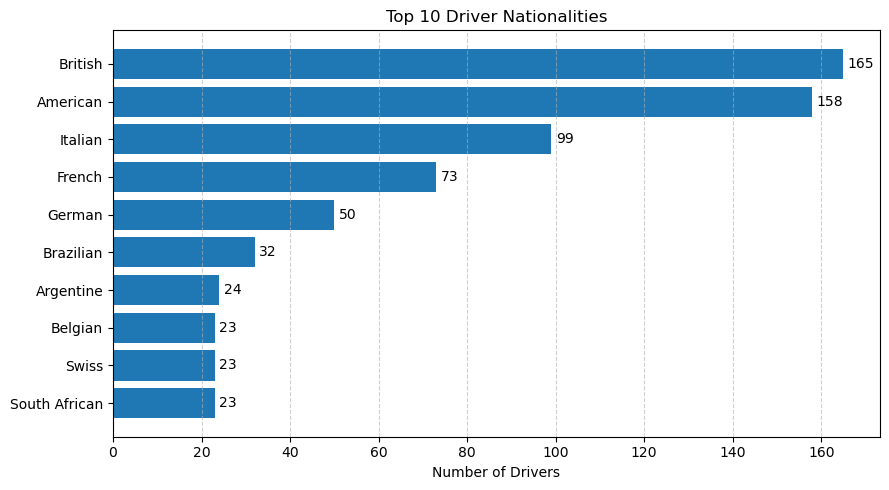

In [74]:
import matplotlib.pyplot as plt


nat_counts = drivers['nationality'].value_counts()
top_nat = nat_counts.head(10)

plt.figure(figsize=(9, 5))
bars = plt.barh(top_nat.index[::-1], top_nat.values[::-1])
plt.xlabel('Number of Drivers')
plt.title('Top 10 Driver Nationalities')
plt.grid(axis='x', linestyle='--', alpha=0.6)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2, str(int(width)), va='center')

plt.tight_layout()
plt.show()


This chart shows the all-time headcount of Formula 1 drivers by nationality. The U.K. tops the list with 165 drivers, narrowly ahead of the U.S. at 158—underscoring both countries’ deep motorsport infrastructures and feeder series. Italy (99) and France (73) follow as the next most prolific talent pools, with Germany (50) rounding out the top five. Beyond Europe’s “Big Four,” Brazil (32) and Argentina (24) reflect South America’s rich F1 heritage, while Belgium, Switzerland, and South Africa each contributed 23 drivers. The sharp decline after the leading nations illustrates how a small group of countries has historically dominated F1’s driver pipeline.

In [75]:
# Permanent number assignment
import pandas as pd

# replace "\\N" with NaN so we can count the number of drivers with and without a permanent number
drivers['number'] = drivers['number'].replace("\\N", pd.NA)

assigned = drivers['number'].notna().sum()
missing  = drivers['number'].isna().sum()

print(f"Drivers with a permanent number: {assigned}")
print(f"Drivers without a permanent number: {missing}")


Drivers with a permanent number: 54
Drivers without a permanent number: 803


Only 54 drivers have a non-null `number` because permanent driver numbers weren’t introduced until 2014. Before then, competitors used whatever number was assigned each weekend, so all pre-2014 drivers (and any who never opted in) appear as missing (`NaN`), accounting for the 803 without a permanent number.


### 2.4 'Races' Dataset Exploration

#### Races Table Schema

From the Ergast codebook, the **races** table is defined with 18 columns:

| Field          | Type           | Null | Key | Default    | Description                                |
|---------------:|:---------------|:-----|:----|:-----------|:-------------------------------------------|
| `raceId`       | `int(11)`      | NO   | PRI | —          | Primary key (auto-increment)               |
| `year`         | `int(11)`      | NO   |     | 0          | Championship season (e.g. 1950)            |
| `round`        | `int(11)`      | NO   |     | 0          | Sequence number within the season          |
| `circuitId`    | `int(11)`      | NO   |     | 0          | Foreign key → `circuits.circuitId`         |
| `name`         | `varchar(255)` | NO   |     | —          | Official race name (e.g. “Monaco Grand Prix”) |
| `date`         | `date`         | NO   |     | `0000-00-00` | Race date (ISO format)                     |
| `time`         | `time`         | YES  |     | —          | Scheduled start time                       |
| `url`          | `varchar(255)` | YES  | UNI | —          | Wikipedia link for the event               |
| `fp1_date`     | `date`         | YES  |     | —          | Free Practice 1 date                       |
| `fp1_time`     | `time`         | YES  |     | —          | Free Practice 1 start time                 |
| `fp2_date`     | `date`         | YES  |     | —          | Free Practice 2 date                       |
| `fp2_time`     | `time`         | YES  |     | —          | Free Practice 2 start time                 |
| `fp3_date`     | `date`         | YES  |     | —          | Free Practice 3 date                       |
| `fp3_time`     | `time`         | YES  |     | —          | Free Practice 3 start time                 |
| `quali_date`   | `date`         | YES  |     | —          | Qualifying session date                    |
| `quali_time`   | `time`         | YES  |     | —          | Qualifying start time                      |
| `sprint_date`  | `date`         | YES  |     | —          | Sprint race date                           |
| `sprint_time`  | `time`         | YES  |     | —          | Sprint race start time                     |


- The first seven fields (`raceId` through `time`) are all non-nullable and form the core metadata we need for merging and analysis.
- All session-specific fields (`fp*`, `quali*`, `sprint*`) allow NULL and are often unused in early seasons; we can ignore or clean these when focusing on main race data.

This schema confirms that our primary keys and join fields are complete and ready for the merges required by our three focused research questions.  

#### Data Exploration

The **Races** dataset captures one row per Grand Prix and includes key scheduling and identification fields—such as `raceId`, `year`, `round`, `circuitId`, `name`, `date`, and `time`. In the code below, we display the first five rows to see the earliest events, call `.info()` to check data types and non‑null counts, and use `.describe(include='all')` to review summary statistics across both numeric and categorical columns.  


In [76]:
# Preview the first 5 rows of the Races dataset
print("Races dataset loaded with", races.shape[0], "rows.")
print("First 5 Rows of the Races Dataset:")
print(races.head(), "\n")

Races dataset loaded with 1102 rows.
First 5 Rows of the Races Dataset:
   raceId  year  round  circuitId                   name        date  \
0       1  2009      1          1  Australian Grand Prix  2009-03-29   
1       2  2009      2          2   Malaysian Grand Prix  2009-04-05   
2       3  2009      3         17     Chinese Grand Prix  2009-04-19   
3       4  2009      4          3     Bahrain Grand Prix  2009-04-26   
4       5  2009      5          4     Spanish Grand Prix  2009-05-10   

       time                                                url fp1_date  \
0  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
1  09:00:00  http://en.wikipedia.org/wiki/2009_Malaysian_Gr...       \N   
2  07:00:00  http://en.wikipedia.org/wiki/2009_Chinese_Gran...       \N   
3  12:00:00  http://en.wikipedia.org/wiki/2009_Bahrain_Gran...       \N   
4  12:00:00  http://en.wikipedia.org/wiki/2009_Spanish_Gran...       \N   

  fp1_time fp2_date fp2_time fp3_date fp3_ti

The code snippet above displays the first five rows of the **Races** table, confirming that each row represents one Grand Prix event. In our sample, we see the opening five races of the 2009 season (Australian, Malaysian, Chinese, Bahrain, Spanish). Key columns—`raceId`, `year`, `round`, `circuitId`, `name`, `date`, `time`, and `url`—are all present and properly formatted. This quick look verifies that our core scheduling and identification fields loaded correctly and are ready for the merges required by our analysis.


In [77]:
print("Dataset Information:")
races.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   raceId       1102 non-null   int64 
 1   year         1102 non-null   int64 
 2   round        1102 non-null   int64 
 3   circuitId    1102 non-null   int64 
 4   name         1102 non-null   object
 5   date         1102 non-null   object
 6   time         1102 non-null   object
 7   url          1102 non-null   object
 8   fp1_date     1102 non-null   object
 9   fp1_time     1102 non-null   object
 10  fp2_date     1102 non-null   object
 11  fp2_time     1102 non-null   object
 12  fp3_date     1102 non-null   object
 13  fp3_time     1102 non-null   object
 14  quali_date   1102 non-null   object
 15  quali_time   1102 non-null   object
 16  sprint_date  1102 non-null   object
 17  sprint_time  1102 non-null   object
dtypes: int64(4), object(14)
memory usage: 155.1+ KB

The output shows **1,102** total entries (index 0–1101) and **18** columns, using about 155 KB of memory. Four integer columns (`raceId`, `year`, `round`, `circuitId`) are fully populated with no missing values, providing robust join keys and season metadata. The other 14 object-type columns include race names, dates/times, and URLs, while the practice (`fp1_*`, `fp2_*`, `fp3_*`), qualifying (`quali_*`), and sprint (`sprint_*`) fields uniformly contain the placeholder “\N” where session data is unavailable. Overall, the completeness of the core fields and clearly marked placeholders for secondary sessions satisfy our assignment’s requirement to document data structure and readiness for analysis.  

In [78]:
print("\nSummary Statistics:")
print(races.describe(include='all'))


Summary Statistics:
             raceId         year        round    circuitId  \
count   1102.000000  1102.000000  1102.000000  1102.000000   
unique          NaN          NaN          NaN          NaN   
top             NaN          NaN          NaN          NaN   
freq            NaN          NaN          NaN          NaN   
mean     553.853902  1992.049002     8.507260    23.697822   
std      321.706151    20.308639     5.097545    19.337398   
min        1.000000  1950.000000     1.000000     1.000000   
25%      276.250000  1976.000000     4.000000     9.000000   
50%      551.500000  1994.000000     8.000000    18.000000   
75%      826.750000  2010.000000    12.000000    34.000000   
max     1120.000000  2023.000000    23.000000    80.000000   

                      name        date  time  \
count                 1102        1102  1102   
unique                  54        1102    34   
top     Italian Grand Prix  2009-03-29    \N   
freq                    74           1   7

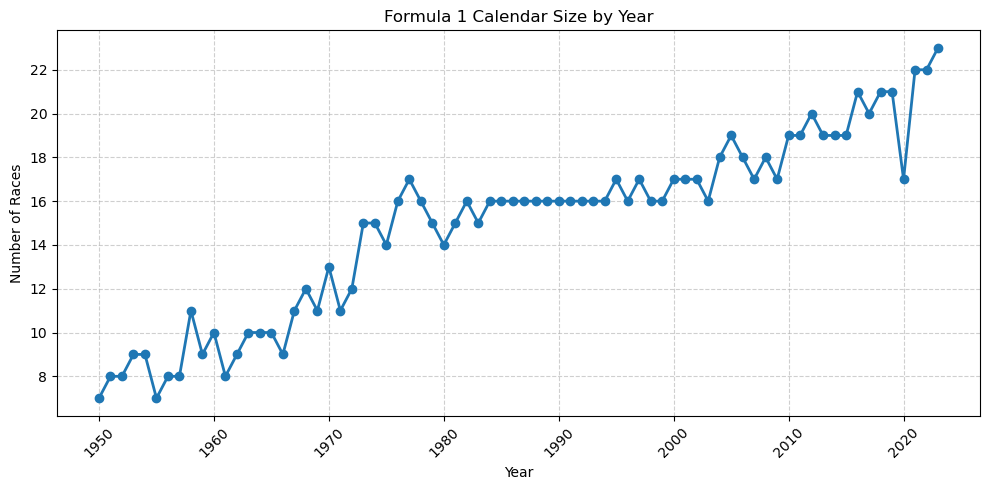

In [79]:
# Compute number of races per year
races_per_year = races['year'].value_counts().sort_index()

# Improved aesthetics
plt.figure(figsize=(10, 5))
plt.plot(races_per_year.index, races_per_year.values, marker='o', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Number of Races')
plt.title('Formula 1 Calendar Size by Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The plot shows how the F1 calendar has steadily expanded since 1950. In the inaugural season there were just seven races; through the 1960s it crept into the low‑10s before jumping to around 15–16 events by the mid‑1970s. From the 1980s through the 1990s the schedule held fairly constant at roughly 16 Grands Prix per year, then climbed again in the 2000s and 2010s into the high‑teens and low‑20s. You can also spot the COVID‑related dip in 2020 (down to 17 races), followed by a post‑pandemic surge peaking at 23 races in 2023. Overall, this upward trend underscores F1’s continual global growth and growing commercial appeal.


###  2.5 'Results' Dataset Exploration


#### Results Table Schema

| Field            | Type            | Null | Key  | Default | Description                                           |
|-----------------:|:----------------|:-----|:-----|:--------|:------------------------------------------------------|
| `resultId`       | `int(11)`       | NO   | PRI  | —       | Primary key (auto-increment)                          |
| `raceId`         | `int(11)`       | NO   |      | 0       | Foreign key → `races.raceId`                          |
| `driverId`       | `int(11)`       | NO   |      | 0       | Foreign key → `drivers.driverId`                      |
| `constructorId`  | `int(11)`       | NO   |      | 0       | Foreign key → `constructors.constructorId`            |
| `number`         | `int(11)`       | YES  |      | —       | Driver number for that race                           |
| `grid`           | `int(11)`       | NO   |      | 0       | Starting grid position                                |
| `position`       | `int(11)`       | YES  |      | —       | Official finishing classification (if applicable)     |
| `positionText`   | `varchar(255)`  | NO   |      | —       | Textual position (e.g. `"1"` or `"R"`)                |
| `positionOrder`  | `int(11)`       | NO   |      | 0       | Numeric position for ordering/comparison              |
| `points`         | `float`         | NO   |      | 0       | Championship points scored in that race               |
| `laps`           | `int(11)`       | NO   |      | 0       | Number of laps completed                              |
| `time`           | `varchar(255)`  | YES  |      | —       | Finishing time or gap (string)                        |
| `milliseconds`   | `int(11)`       | YES  |      | —       | Finishing time in milliseconds                        |
| `fastestLap`     | `int(11)`       | YES  |      | —       | Lap number on which the driver set their fastest lap  |
| `rank`           | `int(11)`       | YES  |      | 0       | Rank of that fastest lap against other drivers         |
| `fastestLapTime` | `varchar(255)`  | YES  |      | —       | Fastest lap time (e.g. `"1:27.453"`)                   |
| `fastestLapSpeed`| `varchar(255)`  | YES  |      | —       | Fastest lap speed (km/h, e.g. `"213.874"`)             |
| `statusId`       | `int(11)`       | NO   |      | 0       | Foreign key → `status.statusId` (finish status code)  |

This **Results** table captures every driver’s outcome in each race: who they drove for (`constructorId`), where they started (`grid`), where they finished (`position`/`positionOrder` and `points`), and their fastest lap details (`fastestLap`, `fastestLapTime`, `rank`, `fastestLapSpeed`). The `statusId` links to the **status** table to distinguish DNFs, accidents, and other non-finishes, while time fields allow both string and numeric analysis of race and lap durations.  


#### Data Exploration

The **Results** dataset catalogs driver performance metrics for each race (e.g., finishing positions, points scored). The exploration code below examines this dataset by displaying its first five rows, detailed dataset information, and summary statistics, providing insights into the various performance metrics available.


In [80]:
# Preview the first 5 rows of the Results dataset
print("Results dataset loaded with", results.shape[0], "rows.")
print("First 5 Rows of the Results Dataset:")
print(results.head())

Results dataset loaded with 25840 rows.
First 5 Rows of the Results Dataset:
   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   
3            4              4     5.0    58      +17.181      5707797   
4            5              5     4.0    58      +18.014      5708630   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0 

The **Results** table contains **25,840** entries—each one recording a single driver’s performance in a particular Grand Prix. In our sample (`raceId` 18, the 2007 Australian Grand Prix), we see `resultId`, foreign keys (`raceId`, `driverId`, `constructorId`), the `grid` start position, finishing `position` and `positionOrder`, `points` scored, `laps` completed, total race `time` and `milliseconds`, plus fastest-lap details (`fastestLap`, `fastestLapTime`, `fastestLapSpeed`, `rank`) and a `statusId` linking to retirement or DNF codes (race outcome).

In [81]:
print("Dataset Information:")
results.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25840 entries, 0 to 25839
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         25840 non-null  int64  
 1   raceId           25840 non-null  int64  
 2   driverId         25840 non-null  int64  
 3   constructorId    25840 non-null  int64  
 4   number           25840 non-null  object 
 5   grid             25840 non-null  int64  
 6   position         25840 non-null  object 
 7   positionText     25840 non-null  object 
 8   positionOrder    25840 non-null  int64  
 9   points           25840 non-null  float64
 10  laps             25840 non-null  int64  
 11  time             25840 non-null  object 
 12  milliseconds     25840 non-null  object 
 13  fastestLap       25840 non-null  object 
 14  rank             25840 non-null  object 
 15  fastestLapTime   25840 non-null  object 
 16  fastestLapSpeed  25840 non-null  obje

The **Results** table contains 25,840 rows across 18 columns. Most fields are complete and appropriately typed—eight are integers (e.g., `raceId`, `grid`, `positionOrder`), while others like `number`, `position`, `time`, and lap statistics are stored as `object` due to mixed formatting or placeholder values (e.g., `"\N"`). Several of these columns—such as `milliseconds`, `fastestLapTime`, and `fastestLapSpeed`—will benefit from cleaning and type conversion for numerical analysis. The final column, `statusId`, links to the **Status** table (see schema above), allowing us to interpret whether a driver finished, retired, or encountered a mechanical issue.


In [82]:
import pandas as pd
import numpy as np

# 1. Replace "\N" placeholders with NaN
results = results.replace("\\N", pd.NA)

# 2. Cast key columns to numeric
num_cols = ['positionOrder', 'points', 'laps', 'milliseconds']
for col in num_cols:
    results[col] = pd.to_numeric(results[col], errors='coerce')

# 3. Parse times into seconds

# 3a. Race time in seconds
results['race_time_s'] = results['milliseconds'] / 1000

# 3b. Fastest lap time in seconds (e.g. "1:27.452" → 87.452)
def lap_time_to_seconds(x):
    if pd.isna(x):
        return np.nan
    minutes, seconds = x.split(':')
    return int(minutes) * 60 + float(seconds)

results['fastestLap_s'] = results['fastestLapTime'].apply(lap_time_to_seconds)


summary = results[['positionOrder', 'points', 'laps', 'race_time_s', 'fastestLap_s']].describe()
print(summary)


       positionOrder        points          laps   race_time_s  fastestLap_s
count   25840.000000  25840.000000  25840.000000   7087.000000   7379.000000
mean       12.876006      1.877053     45.977515   6231.870431     91.112699
std         7.712391      4.169849     29.808951   1678.932890     12.505799
min         1.000000      0.000000      0.000000    207.071000     55.404000
25%         6.000000      0.000000     22.000000   5413.270500     80.908500
50%        12.000000      0.000000     52.000000   5814.618000     90.512000
75%        18.000000      2.000000     66.000000   6426.263500     99.921500
max        39.000000     50.000000    200.000000  15090.540000    202.300000


### 2.6 'Circuits' Dataset Exploration

#### Circuits Table Schema

| Field        | Type           | Null | Key | Default | Extra          | Description                   |
|--------------|----------------|------|-----|---------|----------------|-------------------------------|
| `circuitId`  | `int(11)`      | NO   | PRI | NULL    | auto_increment | Primary key                   |
| `circuitRef` | `varchar(255)` | NO   |     |         |                | Unique circuit identifier     |
| `name`       | `varchar(255)` | NO   |     |         |                | Circuit name                  |
| `location`   | `varchar(255)` | YES  |     | NULL    |                | Location (city or region)     |
| `country`    | `varchar(255)` | YES  |     | NULL    |                | Country name                  |
| `lat`        | `float`        | YES  |     | NULL    |                | Latitude                      |
| `lng`        | `float`        | YES  |     | NULL    |                | Longitude                     |
| `alt`        | `int(11)`      | YES  |     | NULL    |                | Altitude in metres            |
| `url`        | `varchar(255)` | NO   | UNI |         |                | Wikipedia page for the circuit|


The **Circuits** table contains **77** records, one for each Formula 1 venue. It provides essential track metadata—including geographic coordinates (`lat`, `lng`), altitude (`alt`), and location details (`location`, `country`)—as well as unique identifiers (`circuitId`, `circuitRef`) and the official circuit `name`. The `url` field links to each circuit’s Wikipedia page for reference. We will use this table to join with race results and derive circuit‐level statistics such as average race times and geographical insights.  





### Data Exploration

The **Circuits** dataset contains data on race circuits, including circuit names, locations, and geographic coordinates. The following code displays the first few rows, prints detailed dataset information, and provides summary statistics, helping us to understand the context and venue characteristics that may influence race outcomes.




In [83]:
# Preview the first 5 rows of the Circuits dataset
print("Circuits dataset loaded with", circuits.shape[0], "rows.")
print("First 5 Rows of the Circuits Dataset:")
print(circuits.head(), "\n")

Circuits dataset loaded with 77 rows.
First 5 Rows of the Circuits Dataset:
   circuitId   circuitRef                            name      location  \
0          1  albert_park  Albert Park Grand Prix Circuit     Melbourne   
1          2       sepang    Sepang International Circuit  Kuala Lumpur   
2          3      bahrain   Bahrain International Circuit        Sakhir   
3          4    catalunya  Circuit de Barcelona-Catalunya      Montmeló   
4          5     istanbul                   Istanbul Park      Istanbul   

     country       lat        lng  alt  \
0  Australia -37.84970  144.96800   10   
1   Malaysia   2.76083  101.73800   18   
2    Bahrain  26.03250   50.51060    7   
3      Spain  41.57000    2.26111  109   
4     Turkey  40.95170   29.40500  130   

                                                 url  
0  http://en.wikipedia.org/wiki/Melbourne_Grand_P...  
1  http://en.wikipedia.org/wiki/Sepang_Internatio...  
2  http://en.wikipedia.org/wiki/Bahrain_Internati...  


The **Circuits** table contains 77 entries—one for each F1 venue. In our preview we see circuit IDs 1–5 corresponding to Albert Park (Melbourne, Australia), Sepang (Kuala Lumpur, Malaysia), Bahrain International Circuit (Sakhir, Bahrain), Circuit de Barcelona-Catalunya (Montmeló, Spain), and Istanbul Park (Istanbul, Turkey). Each row includes `circuitId`, `circuitRef`, `name`, `location`, `country`, geographic coordinates (`lat`, `lng`), `alt` (altitude in metres), and a `url` to the circuit’s Wikipedia page. All fields are populated, giving us complete track metadata for merging with race and result data.

In [84]:
print("Dataset Information:")
circuits.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   circuitId   77 non-null     int64  
 1   circuitRef  77 non-null     object 
 2   name        77 non-null     object 
 3   location    77 non-null     object 
 4   country     77 non-null     object 
 5   lat         77 non-null     float64
 6   lng         77 non-null     float64
 7   alt         77 non-null     object 
 8   url         77 non-null     object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.5+ KB


Although the **Circuits** schema allows `location`, `country`, `lat`, `lng`, and `alt` to be null, our loaded table contains **77** records and **9** columns with **no missing values**. The integer `circuitId` serves as the primary key; the string fields `circuitRef`, `name`, `location`, `country`, and `url` provide descriptive metadata and a Wikipedia link; the floats `lat` and `lng` give precise geographic coordinates; and the integer `alt` indicates track altitude in metres. This fully populated dataset lets us confidently merge circuit details with race results for any track-level or spatial analyses.  

In [85]:
print("\nSummary Statistics:")
print(circuits.describe(include='all'))


Summary Statistics:
        circuitId   circuitRef                            name   location  \
count   77.000000           77                              77         77   
unique        NaN           77                              77         75   
top           NaN  albert_park  Albert Park Grand Prix Circuit  Barcelona   
freq          NaN            1                               1          2   
mean    39.883117          NaN                             NaN        NaN   
std     23.001701          NaN                             NaN        NaN   
min      1.000000          NaN                             NaN        NaN   
25%     20.000000          NaN                             NaN        NaN   
50%     40.000000          NaN                             NaN        NaN   
75%     59.000000          NaN                             NaN        NaN   
max     80.000000          NaN                             NaN        NaN   

       country        lat         lng  alt  \
count   

Summary statistics for `lat`, `lng`, and `alt` offer limited insight. Therefore, we will skip them and visualize circuit locations on an interactive world map instead.

In [86]:
import pandas as pd
import folium
import os


circuits['lat'] = pd.to_numeric(circuits['lat'], errors='coerce')
circuits['lng'] = pd.to_numeric(circuits['lng'], errors='coerce')

m = folium.Map(location=[20, 0], zoom_start=2)

for _, row in circuits.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=f"<b>{row['name']}</b><br>{row['location']}, {row['country']}",
        tooltip=row['name']
    ).add_to(m)

m


That map makes it immediately clear that Formula 1 is still very much a Northern‐Hemisphere, Western‐European–centric championship, with a heavy cluster of circuits across the UK, Germany, Italy, France and their neighbors. There are secondary hubs in North America (the U.S. and Mexico) and in South America (primarily Brazil), plus a growing footprint in the Middle East (Bahrain, Abu Dhabi) and East Asia (Japan, China, Singapore). Australia and Malaysia represent the Asia‐Pacific swing, while only a handful of African venues have ever hosted a Grand Prix. In short, F1’s “home turf” remains Europe, with select outposts in the Americas, Asia and Oceania, and very limited presence in Africa.

### 2.7 Data Preparation 

- Data Cleaning and Data Merging for RQ1-3


Based on the Ergast ERD, our five selected tables connect as follows:

1. **Drivers** (`driverId`) ⟶ **Results** (`driverId`)  
   *Each result row tells us which driver achieved that grid start, finishing position, fastest lap, etc.*

2. **Races** (`raceId`) ⟶ **Results** (`raceId`)  
   *Each result is tied back to a specific Grand Prix.*

3. **Races** (`circuitId`) ⟶ **Circuits** (`circuitId`)  
   *Each race happens at a known circuit, so we can pull in track metadata.*

4. **Results** (`statusId`) ⟶ **Status** (`statusId`)  
   *To filter only classified finishes (e.g. “Finished” or “+n Laps”).*



So for each analysis we have:

- **Podium by Nationality**:  
  Results ⟶ Drivers  
- **Circuit Speed**:  
  Results ⟶ Races ⟶ Circuits ⟶ Status  
- **Nationality Trends**:  
  Results ⟶ Drivers + Results ⟶ Races  


#### RQ1: Podium by Nationality

**Data cleaning**  
In the raw **Results** table, the `positionOrder` column is stored as text and uses `"\N"` to indicate missing values, which prevents any numeric comparison. We:

1. Replace all `"\N"` placeholders with `pd.NA`.  
2. Cast `positionOrder` to an integer type so we can reliably test for top-three finishes.  
3. Create a Boolean `podium` column that flags every row where `positionOrder ≤ 3`.  

After these steps, our cleaned DataFrame (`results_rq1`) has exactly three columns—`driverId`, `positionOrder` (int), and `podium` (bool)—ready to merge.  

> **Note**: The Drivers table’s nationality field is non-nullable by schema, so no additional cleaning is needed on that side.


In [87]:
# 1. Replace "\N" with actual missing values and cast to numeric
results_rq1 = (
    results
    .replace("\\N", pd.NA)
    .assign(
        positionOrder=lambda df: pd.to_numeric(df['positionOrder'], errors='coerce'),
    )
)

# 2. Flag any finish in the top three as a podium
results_rq1['podium'] = results_rq1['positionOrder'] <= 3

# Verify
print(results_rq1[['positionOrder','podium']].head())


   positionOrder  podium
0              1    True
1              2    True
2              3    True
3              4   False
4              5   False


**Merging procedures**  
To link each podium flag with its driver’s nationality, we perform a left‐join of our cleaned `results_rq1` to the **Drivers** table on `driverId`. This brings in the `nationality` column for every result row. We then drop any rows where `nationality` is missing (to exclude historic drivers with unknown nationalities). The resulting `rq1` DataFrame contains four columns—`driverId`, `positionOrder`, `podium`, and `nationality`—so we can immediately compute podium counts by country.


In [88]:
# Merge in nationality and drop any missing entries
rq1 = (
    results_rq1[['driverId','positionOrder','podium']]
    .merge(
        drivers[['driverId','nationality']],
        on='driverId',
        how='left'
    )
    .dropna(subset=['nationality'])
)

# Quick check
print("RQ1 sample:")
print(rq1.head())

RQ1 sample:
   driverId  positionOrder  podium nationality
0         1              1    True     British
1         2              2    True      German
2         3              3    True      German
3         4              4   False     Spanish
4         5              5   False     Finnish



### RQ2: Circuit Speed  

**Data cleaning**
To calculate reliable per-circuit speeds, we first clean **Results** so that all time fields are numeric and we only keep classified finishers:

In [89]:
# 1. Bring in circuit name & country
rq2 = (
    results
    .merge(
        circuits[['circuitId', 'name', 'country']],
        on='circuitId',
        how='left'
    )
)

# 2. Group by circuit to get per-track averages
circuit_stats = (
    rq2
    .groupby(['circuitId', 'name', 'country'], as_index=False)
    .agg(
        avg_race_time_s  = ('race_time_s',   'mean'),
        avg_fastestLap_s = ('fastestLap_s',  'mean'),
        n_finishers      = ('resultId',      'count')
    )
)

# 3. Quick sanity check
print("Sample circuit speed stats:")
print(circuit_stats.head())


KeyError: 'circuitId'


### RQ3: Nationality Trends Over Time  
For decade‐by‐decade podium trends, we brought together **Results**, **Races**, and **Drivers**. We first merged `Results` with `Races` to get every result’s exact race date, then grouped by `driverId` to find each driver’s earliest Grand Prix date. Converting that to `debut_year` and flooring to the nearest decade gave us a `debut_decade` for every driver. We merged this back into **Drivers**, then rebuilt our main table by joining **Results → Races → Drivers** and reapplying the `podium` flag. Now each row carries a nationality, a debut decade, and a podium indicator—perfect for plotting how different countries’ drivers have risen (or faded) in top-3 finishes across the decades.

In [367]:
'''
Steps for RQ3:
1. Merge Results → Races to pull in the actual race DATE for each result.
2. Convert `date` to datetime and find each driver’s earliest `debut_date`.
3. From `debut_date`, extract `debut_year` and compute `debut_decade` = floor(debut_year/10)*10.
4. Merge both `debut_date` and `debut_decade` back into Drivers.
5. Build the RQ3 table by joining Results → Races → Drivers and flagging any finish
   with positionOrder ≤ 3 as a podium.
'''

driver_race_dates = (
    results[['driverId','raceId']]
    .merge(races[['raceId','date']], on='raceId', how='left')
)

driver_race_dates['date'] = pd.to_datetime(driver_race_dates['date'], errors='coerce')
first_race = (
    driver_race_dates
    .groupby('driverId', as_index=False)
    .agg(debut_date=('date','min'))
)


first_race['debut_year'] = first_race['debut_date'].dt.year
first_race['debut_decade'] = (first_race['debut_year'] // 10) * 10

drivers = drivers.merge(
    first_race[['driverId','debut_date','debut_decade']],
    on='driverId',
    how='left'
)


rq3 = (
    results
    .merge(races[['raceId','year']], on='raceId', how='left')
    .merge(drivers[['driverId','nationality','debut_date','debut_decade']], on='driverId', how='left')
    .assign(podium=lambda df: df['positionOrder'] <= 3)
)

print("Distinct debut decades in RQ3:", sorted(rq3['debut_decade'].dropna().unique()))
print("\nSample of driver debuts:")
print(
    drivers[['driverId','forename','surname','debut_date','debut_decade']]
    .sort_values('debut_date')
    .head(10)
)


Distinct debut decades in RQ3: [1950.0, 1960.0, 1970.0, 1980.0, 1990.0, 2000.0, 2010.0, 2020.0]

Sample of driver debuts:
     driverId  forename       surname debut_date  debut_decade
627       627     Louis        Rosier 1950-05-13        1950.0
589       589     Louis        Chiron 1950-05-13        1950.0
778       778     Brian  Shawe Taylor 1950-05-13        1950.0
747       747     David        Murray 1950-05-13        1950.0
579       579      Juan        Fangio 1950-05-13        1950.0
619       619       Bob        Gerard 1950-05-13        1950.0
666       666      Tony          Rolt 1950-05-13        1950.0
741       741  Philippe     Étancelin 1950-05-13        1950.0
660       660    Johnny         Claes 1950-05-13        1950.0
669       669    Prince          Bira 1950-05-13        1950.0
